In [1]:
%matplotlib inline
import gym
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
class LinearAgent:
    def __init__(self):
        self.theta = np.ndarray([4], dtype=np.float32)

    def action(self, state):
        prod = self.theta.T @ state
        return np.int64(prod >= 0)

    def __repr__(self):
        return str(self.theta)

    @classmethod
    def random_normal(cls, mean=0.0, stdev=1.0):
        agent = cls()
        agent.theta = np.random.normal(mean, stdev, size=agent.theta.size)
        return agent

In [3]:
class Evaluator:
    def __init__(self, env):
        self.env = env

    def evaluate(this, agent, cumulative=True, render=False):
        done, rewards, state = False, [], this.env.reset()
        while not done:
            if render is True:
                this.env.render(mode='human')
            action = agent.action(state)
            state, reward, done, _ = this.env.step(action)
            rewards.append(reward)
        return sum(rewards) if cumulative else rewards

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Best Random Guessing Agent (107.0) = [ 0.04454139 -0.31768042  0.6295203   1.06514808]


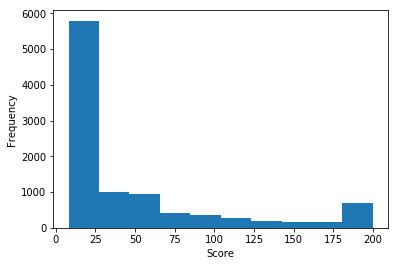

In [4]:
def random_guessing(evaluator):
    with mp.Pool() as pool:
        agents = pool.starmap(LinearAgent.random_normal, [(0.0, 1.0)] * 10_000)
        rewards = pool.map(evaluator.evaluate, agents)
    best_reward, best_agent = max(zip(rewards, agents), key=lambda tpl: tpl[0])
    
    plt.hist(rewards)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    return best_agent

evaluator = Evaluator(gym.make('CartPole-v0'))
agent = random_guessing(evaluator)
score = evaluator.evaluate(agent, render=True)
print("Best Random Guessing Agent ({}) = {}".format(score, agent))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Best Random Guessing Agent (200.0) = [ 0.04454139 -0.31768042  0.6295203   1.06514808]


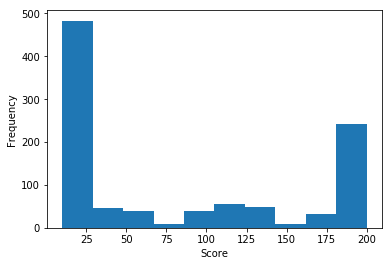

In [5]:
def hill_climb(_):
    eval = 0
    agent = LinearAgent.random_normal(0.0, 1.0)
    score = evaluator.evaluate(agent)
    while score < 200 and eval < 500:
        pert_theta = np.random.normal(0.0, 0.0, size=agent.theta.size)
        agent.theta += pert_theta
        pert_score = evaluator.evaluate(agent)
        if pert_score > score:
            score = pert_score
        else:
            agent.theta -= pert_theta
        eval += 1
    return score


def hill_climbing(evaluator):
    with mp.Pool() as pool:
        scores = pool.map(hill_climb, range(1_000))

    plt.hist(scores)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    return agent


evaluator = Evaluator(gym.make('CartPole-v0'))
agent = hill_climbing(evaluator)
score = evaluator.evaluate(agent, render=True)
print("Best Random Guessing Agent ({}) = {}".format(score, agent))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Best Policy Gradient Agent (200.0) = [0.02003352 0.03421637 0.03384081 0.0351791 ]


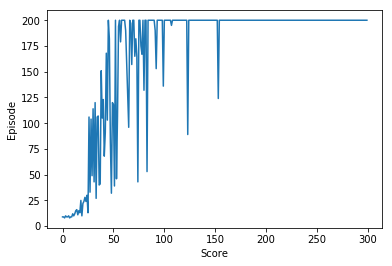

In [51]:
class LinearStochasticAgent(LinearAgent):
    def __init__(self):
        super().__init__()
        self.grad_logprobs = []
        self.eps = 0.1

    def action(self, state):
        prod = self.theta.T @ state
        prob = 1 / (1 + np.exp(-prod))
        self.grad_logprobs.append(state * (1 - prob))
        if np.random.uniform() < self.eps:
            action = np.random.randint(0, 1)
        else:
            action = 0 if prob <= 0.5 else 1
        return action

    def update(self, rewards, lr=1e-5):
        assert len(self.grad_logprobs) == len(rewards)
        grad_reward = np.array(self.grad_logprobs).T @ np.array(rewards)
        self.theta += lr * grad_reward
        self.grad_logprobs = []


def policy_gradient(evaluator):
    agent = LinearStochasticAgent.random_normal(0.0, 0.05)
    scores = []
    for i in range(300):
        agent.eps = 10 / (i + 1)
        rewards = evaluator.evaluate(agent, cumulative=False)
        agent.update(rewards)
        scores.append(sum(rewards))
    agent.train = False
    
    plt.plot(scores)
    plt.xlabel('Score')
    plt.ylabel('Episode')
    return agent


evaluator = Evaluator(gym.make('CartPole-v0'))
agent = policy_gradient(evaluator)
score = evaluator.evaluate(agent, render=True)
print("Best Policy Gradient Agent ({}) = {}".format(score, agent))

